# Dataset Exploration

Used to generate figures which explore and illustrate the composition of the train and test data sets.

In [1]:
import os
import sys
import xmltodict
from collections import OrderedDict
import imageio.v3 as iio
from pathlib import Path
from copy import deepcopy
from pprint import pprint

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from turbx import REPO_PATH, log
from turbx.data import DataLoader, Dataset

# max number of frames per video
MAX_LEN=300
FPS=10.0

sns.set_theme()

media_path = Path("./media")
os.makedirs(media_path, exist_ok=True)

[DEBUG] 12/07/2022 05:43:31PM: MainProcess: __init__.py - Loaded logging config file: /Users/nowa201/Code/fish_detector/turbx/src/turbx/logging.yaml


In [2]:
# DATA PROCESSING FUNCTIONS

def labels_to_pos_frames(label):
    pos_frames = [ 0 for _ in range(label['video_length'])]
    for t in label['tracks']:
        for f in t['frames']:
            pos_frames[f['frame'] - label['start_frame']] = 1
    
    return sum(pos_frames)

In [3]:
label_path = f"{REPO_PATH}/data/labels/cvat-video-1.1"
video_path = f"{REPO_PATH}/data/mp4"
train_dataset = Dataset(videos=video_path, labels=label_path)

label_path = f"{REPO_PATH}/data/labels/cvat-video-1.1/test"
video_path = f"{REPO_PATH}/data/mp4/test"
test_dataset = Dataset(videos=video_path, labels=label_path)

train_data = train_dataset.aligned_data['train']
test_data = test_dataset.aligned_data['test']

[INFO] 12/07/2022 05:43:31PM: MainProcess: data.py - Initializing Dataset...
[INFO] 12/07/2022 05:43:31PM: MainProcess: data.py - 393 video files found
[INFO] 12/07/2022 05:43:31PM: MainProcess: data.py - Initializing Dataset...
[INFO] 12/07/2022 05:43:31PM: MainProcess: data.py - 17 video files found


In [4]:
train_lengths = []
train_n_targets = []
train_n_pos_frames = []
for _, label in train_data:
    train_lengths.append(label["video_length"])
    train_n_targets.append(len(label["tracks"])) # n targets in video
    train_n_pos_frames.append(labels_to_pos_frames(label)) # n frames with target in video

In [5]:
test_lengths = []
test_n_targets = []
test_n_pos_frames = []
for _, label in test_data:
    test_lengths.append(label["video_length"])
    test_n_targets.append(len(label["tracks"])) # n targets in video
    test_n_pos_frames.append(labels_to_pos_frames(label)) # n frames with target in video

In [30]:
# POST PROCESS METHODS
def calc_target_density(targets, lengths):
    assert(len(targets) == len(lengths))
    target_densities = [ t/l for t, l in zip(targets, lengths)]
    return target_densities

# TODO: align yticks for both axes - https://stackoverflow.com/questions/26752464/how-do-i-align-gridlines-for-two-y-axis-scales-using-matplotlib
def plot_length_histogram(video_lengths, n_targets, dataset="train", format="svg", save=False):
    fig, ax = plt.subplots(constrained_layout=True)
    ax.grid(linestyle='-', zorder=0)
    ax2=ax.twinx()
    ax2.grid(False)
    #ax2.set_axisbelow(True)
    #ax2.grid(linestyle='--', zorder=0)

    ax.set_xlabel("Video Length")
    ax.set_ylabel("Number of Videos", color=sns.color_palette()[0])
    ax.hist(x=video_lengths, bins=10, color=sns.color_palette()[0])

    ax2.set_ylabel("Per-Video Target Density", color=sns.color_palette()[1])
    target_densities = calc_target_density(n_targets, video_lengths)
    ax2.plot(video_lengths, target_densities, '.', color=sns.color_palette()[1])

    plt.title(f"{dataset.capitalize()} Set")
    plt.savefig(f"{str(media_path)}/{dataset}-info.{format}", format=format) if save else None

def calc_statistics(lengths, targets, pos_frames):
    target_prob = (1/len(lengths)) * sum([t/l for t, l in zip(pos_frames, lengths)])
    pprint(f"P(Target in Frame): {target_prob}")
    df = pd.Series(lengths)
    pprint(df.describe())

def plot_dataset_sparsity():
    pass

'P(Target in Frame): 0.16706168170696936'
count     21.000000
mean     191.857143
std      145.485836
min       33.000000
25%       93.000000
50%      160.000000
75%      228.000000
max      676.000000
dtype: float64


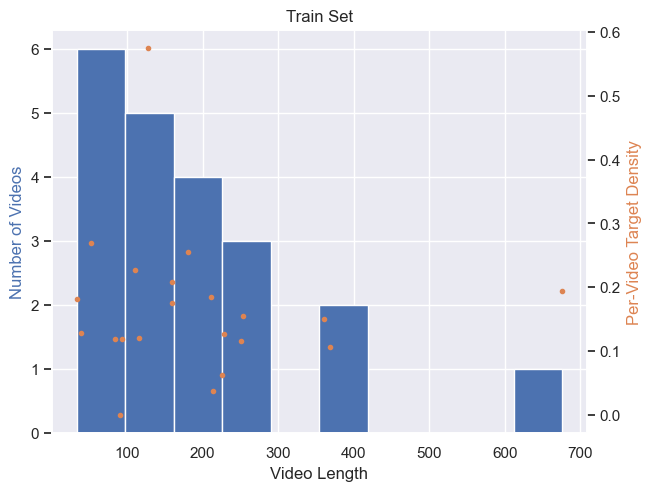

In [31]:
plot_length_histogram(train_lengths, train_n_pos_frames, dataset="train", format="pdf", save=True)
calc_statistics(train_lengths, train_n_targets, train_n_pos_frames)

'P(Target in Frame): 0.01113016432285143'
count      17.000000
mean     6083.647059
std       587.519355
min      4879.000000
25%      5738.000000
50%      6157.000000
75%      6224.000000
max      7211.000000
dtype: float64


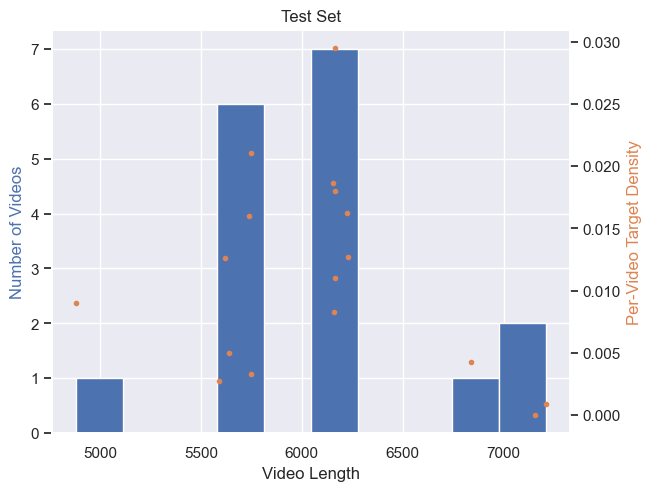

In [32]:
plot_length_histogram(test_lengths, test_n_pos_frames, dataset="test", format="pdf", save=True)
calc_statistics(test_lengths, test_n_targets, test_n_pos_frames)